# Load Dataset

In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# Feature Engineering and Model Selection Modules
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Deep Learning Modules
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2

data = pd.read_csv('datafinal.csv')[
    ['flair', 'id', 'combined_features']
].rename(columns={'combined_features': 'text'})
data

,flair,id,text
0,AskIndia,fwjdqr,4 days ago pending orders 100 million hydroxyc...
1,AskIndia,fizkkk,randians big time users dating apps like tinde...
2,AskIndia,f25vx0,r india thinks flat earthershavent found india...
3,AskIndia,dtvliq,people left 9 5 jobs pursue career music art f...
4,AskIndia,b7pvwt,somebody want kill full familycalm downgo sp o...
...,...,...,...
1213,Coronavirus,fxxxrn,actual coronavirus cases least four times repo...
1214,Coronavirus,fy7ut2,donate helping coronavirusstate government fun...
1215,Coronavirus,fxul63,youth beaten female doctors attacked delhi pre...
1216,Coronavirus,fy3n43,coronavirus centre concerned polarisation reli...


# Encode the Labels

In [316]:
le = LabelEncoder()
le.fit(data['flair'])
data['n_flair'] = le.transform(data['flair'])
data.head()

,flair,id,text,n_flair
0,AskIndia,fwjdqr,4 days ago pending orders 100 million hydroxyc...,1
1,AskIndia,fizkkk,randians big time users dating apps like tinde...,1
2,AskIndia,f25vx0,r india thinks flat earthershavent found india...,1
3,AskIndia,dtvliq,people left 9 5 jobs pursue career music art f...,1
4,AskIndia,b7pvwt,somebody want kill full familycalm downgo sp o...,1


# Explore Data
## Collect Key Metrics

In [317]:
n_samples = len(data)
n_classes = len(list(set(data['flair'])))
n_samples_per_class = data['flair'].value_counts().to_dict()
median_words_per_sample = [
    np.median(
        data[data['flair'] == f]['text'].str.len()
    ) for f in list(set(data['flair']))]
                                                                                                  
print(f'Number of samples: {n_samples}')
print('--')
print(f'Number of classes: {n_classes}')
print('--')
print('Number of samples per class:')
for key, value in n_samples_per_class.items():
    print(f'    {key}: {value}')
print('--')
print(f'Median length of text:')
for c, l in list(zip(list(
    set(data['flair'])), median_words_per_sample)):
    print(f'    {c}: {l}')

Number of samples: 1218
--
Number of classes: 13
--
Number of samples per class:
    Politics: 100
    Sports: 100
    Food: 100
    Scheduled: 100
    Coronavirus: 100
    Science/Technology: 100
    AskIndia: 100
    Non-Political: 100
    Photography: 100
    Business/Finance: 100
    Policy/Economy: 100
    AMA: 100
    [R]eddiquette: 18
--
Median length of text:
    Sports: 1108.0
    AMA: 3171.5
    Food: 992.5
    Coronavirus: 365.5
    Politics: 1134.0
    Scheduled: 1188.5
    Non-Political: 711.5
    AskIndia: 1314.0
    Policy/Economy: 2485.5
    Science/Technology: 1376.0
    Business/Finance: 2665.0
    Photography: 524.5
    [R]eddiquette: 1410.0


## Plot Frequency Distribution of N-Grams

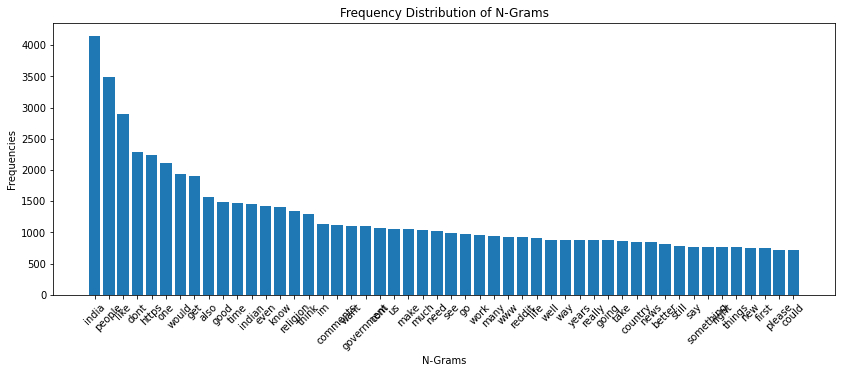

In [318]:

def plot_ngrams(sample_texts, ngram_range=(1, 2), n_ngrams=50):
    """Plots the frequency distribution of n-grams.
    
    Parameters
    ----------
    sample_texts : list
        Sample texts
    ngram_range : tuple
        The range of n-gram values to consider.
    n_ngrams : int
        Number of n-grams to plot
    """
    # Create arguments for vectorizing
    kwargs = {
        'ngram_range': (1, 1),
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': 'word'
    }
    
    cv = CountVectorizer(**kwargs)
    
    # Create vocabulary (dict, with keys as n-grams and values as
    # indices). Converts every text to array length of vocabulary,
    # the elements of which are the count of each n-gram
    vectorized_texts = cv.fit_transform(sample_texts)
    all_ngrams = list(cv.get_feature_names())
    n_ngrams = min(n_ngrams, len(all_ngrams))
    
    # Add up counts per n-gram, one row per n-gram, hence axis=0
    counts = vectorized_texts.sum(axis=0).tolist()[0]
    
    # Sort n-grams and counts by freq. and get top n n-grams
    counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
    zip(counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:n_ngrams]
    cnts = list(counts)[:n_ngrams]
    
    idx = np.arange(n_ngrams)
    plt.figure(figsize=(14, 5))
    plt.bar(idx, cnts, width=0.8)
    plt.xlabel('N-Grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency Distribution of N-Grams')
    plt.xticks(idx, ngrams, rotation=45)

plot_ngrams(data['text'])

## Plot the Number of Words Per Sample

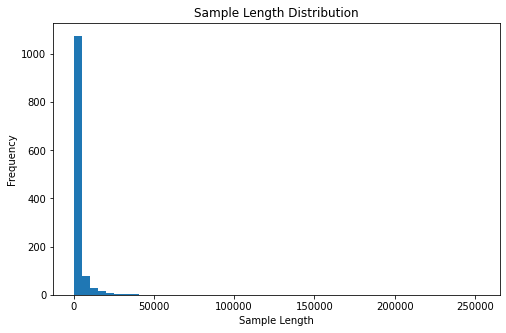

In [319]:
def plot_words_per_sample(sample_texts):
    """Plots the sample length distribution
    
    Parameters
    ----------
    sample_texts : list
        Sample texts
    
    """
    plt.figure(figsize=(8, 5))
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Sample Length')
    plt.ylabel('Frequency')
    plt.title('Sample Length Distribution')

plot_words_per_sample(data['text'])

# Text Preprocessing
Tasks like lemmatization and stop word removal can be problematic for sentiment analysis and have been shown to be detrimental to accuracy, so we'll just be removing the punctuation.

In [320]:
data['text'] = data['text'].str.replace('[^\w\s]', '')
data['text']

0       4 days ago pending orders 100 million hydroxyc...
1       randians big time users dating apps like tinde...
2       r india thinks flat earthershavent found india...
3       people left 9 5 jobs pursue career music art f...
4       somebody want kill full familycalm downgo sp o...
                              ...                        
1213    actual coronavirus cases least four times repo...
1214    donate helping coronavirusstate government fun...
1215    youth beaten female doctors attacked delhi pre...
1216    coronavirus centre concerned polarisation reli...
1217    coronavirus pooled testing planned zerocase di...
Name: text, Length: 1218, dtype: object

# Choose the Model
> How do we present the text data to an algorithm that expects numeric input?

In order for us to get an idea of the complexity of the model we'll be using, we should first calculate the ratio of the number of samples to the number of words per sample.

In [321]:
# Divide two lists
ratio = [i / j for i, j in zip(median_words_per_sample, list(n_samples_per_class.values()))]
avg_ratio = sum(ratio) / len(ratio)
avg_ratio

19.130641025641026

Thankfully, this is a very small ratio compared to what we would need to build complex CNNs. We'll need to tokenize the text as sequences and classify them with a multi-layer perceptron. 
# Train/Test Split
It is good practice to shuffle our data before feeding it into a model so it won't be affected by data order. `train_test_split` does this by default, with `shuffle` set to `True`.

In [322]:
X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['n_flair'], test_size=0.2, random_state=42)

print(X_train, y_train)

432     redditors kolkatananhttpswwwredditcomrindiacom...
277     security personnel bjp mp chairman national co...
721     questions indian billionaires private indian c...
1062    optilasik procedure bangalore right eye 4 sph ...
678     initial thoughts reactions union budget 2019th...
                              ...                        
1044    unverified ama worked amazon customer service ...
1095    ama request married porn sex masturbation addi...
1130    coronavirus india cant depend un old world ord...
860     delhi cabinet approves setting sports universi...
1126    india boost drug ingredient output pare china ...
Name: text, Length: 974, dtype: object 432     10
277      9
721      7
1062     0
678      2
        ..
1044     0
1095     0
1130     3
860     11
1126     3
Name: n_flair, Length: 974, dtype: int64


# Prepare the Data
First, get the indices to make our predictions later. Then, we'll need to tokenize our dataset to build its vocabulary. We'll tokenize it into unigrams and bigrams, and then generate a TF-IDF vector of the length of the vocabulary.

In [323]:
train_idxs = list(X_train.index)
test_idxs = list(X_test.index)
print(train_idxs[:10])
print(test_idxs[:10])

[432, 277, 721, 1062, 678, 599, 306, 289, 812, 596]
[541, 259, 43, 1008, 584, 310, 657, 1211, 210, 155]


In [324]:
kwargs = {
    'ngram_range': (1, 2),
    'dtype': 'int32',
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': 'word',
    'min_df': 2 # document/corpus freq. below which a token will be discarded
}

vec = TfidfVectorizer(**kwargs)

train_tfidf = vec.fit_transform(X_train)
test_tfidf = vec.transform(X_test)

print(train_tfidf.shape, test_tfidf.shape)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1796: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn("Only {} 'dtype' should be used. {} 'dtype' will "


(974, 52609) (244, 52609)


We have 1,218 samples, and ~50-60,000 total features extracted by the TF-IDF vectorizer.
## Feature Selection
Use the ANOVA f-value to pick the top 20,000 features from the vector of tokens.

In [325]:
TOP_K = 500

select = SelectKBest(f_classif, k=min(TOP_K, test_tfidf.shape[1]))

select.fit(train_tfidf, y_train)
X_train = select.transform(train_tfidf).toarray().astype('float32')
X_test = select.transform(test_tfidf).toarray().astype('float32')

print(X_train.shape, X_test.shape)

(974, 500) (244, 500)


## Final Model Data

In [326]:
model_data = (X_train, y_train), (X_test, y_test)
model_data

((array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  432     10
  277      9
  721      7
  1062     0
  678      2
          ..
  1044     0
  1095     0
  1130     3
  860     11
  1126     3
  Name: n_flair, Length: 974, dtype: int64),
 (array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.02655824],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.03206171],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0. 

# Building and Training the Model
We are building a model that processes individual tokens (i.e., not worrying about word order). Multi-layer perceptrons typically perform best with n-gram models, so that's what we'll be building using `keras`.

In [327]:
def build_model(n_layers, units, dropout_rate, reg_factor, input_shape, n_classes):
    """Builds n-gram model
    
    Parameters
    ----------
    n_layers : int
        Number of Dense layers in model
    units : int
        Output dimension of layers
    dropout_rate : float
        Percentage of input to drop at Dropout layers
    input_shape : tuple
        Shape of input to the model
    n_classes : int
        Number of input classes
        
    Returns
    -------
    Fully-connected model
    """
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))
    
    for _ in range(n_layers - 1):
        model.add(Dense(units=units, activation='relu', kernel_regularizer=l2(reg_factor)))
        model.add(Dropout(rate=dropout_rate))
        
    model.add(Dense(n_classes, 'softmax'))
    return model

def train_model(data, 
                lr=0.001, 
                epochs=1000, 
                batch_size=32, 
                n_layers=2, 
                units=64, 
                dropout_rate=0.3,
                reg_factor=1e-5,
                print_history=True):
    """Trains n-gram model
    
    Parameters
    ----------
    data : tuple
        Tuple containing tuples of training and testing text and labels
    learning_rate : float
        Learning rate for optimizer
    epochs : int
        Number of epochs
    batch_size : int
        # of samples per batch
    layers : int
        Number of Dense layers in model
    units : int
        Output dimension of Dense layers
    dropout_rate : float
        Percentage of input to drop at Dropout layers
    """
    (text_train, labels_train), (text_test, labels_test) = data
    n_classes = 13
    
    # Create model instance
    model = build_model(
        n_layers=n_layers,
        units=units,
        dropout_rate=dropout_rate,
        reg_factor=reg_factor,
        input_shape=text_train.shape[1:],
        n_classes=n_classes
    )
    
    loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
    
    # Early stopping
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]
    
    if print_history == True:
        VERBOSE = 2
    else:
        VERBOSE = 0
    
    # Train and validate
    history = model.fit(
        text_train,
        labels_train,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(text_test, labels_test),
        verbose=VERBOSE,
        batch_size=batch_size
    )
    
    history = history.history    
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    # Plot history: Loss
    plt.plot(history['val_loss'], label='val_loss')
    plt.plot(history['loss'], label='loss')
    plt.title('Loss and Validation Loss History')
    plt.ylabel('Loss Value')
    plt.xlabel('No. Epoch')
    plt.legend()
    plt.show()

    # Plot history: Accuracy
    plt.plot(history['val_acc'], label='val_acc')
    plt.plot(history['acc'], label='acc')
    plt.title('Accuracy and Validation Accuracy History')
    plt.ylabel('Accuracy Value (%)')
    plt.xlabel('No. Epoch')
    plt.legend()
    plt.show()

    return model

Epoch 1/1000
31/31 - 0s - loss: 2.5535 - acc: 0.1674 - val_loss: 2.5306 - val_acc: 0.3893
Epoch 2/1000
31/31 - 0s - loss: 2.5110 - acc: 0.3265 - val_loss: 2.4737 - val_acc: 0.4877
Epoch 3/1000
31/31 - 0s - loss: 2.4537 - acc: 0.4148 - val_loss: 2.4032 - val_acc: 0.5369
Epoch 4/1000
31/31 - 0s - loss: 2.3863 - acc: 0.4949 - val_loss: 2.3298 - val_acc: 0.6270
Epoch 5/1000
31/31 - 0s - loss: 2.3177 - acc: 0.5226 - val_loss: 2.2604 - val_acc: 0.6311
Epoch 6/1000
31/31 - 0s - loss: 2.2407 - acc: 0.5688 - val_loss: 2.1879 - val_acc: 0.6926
Epoch 7/1000
31/31 - 0s - loss: 2.1728 - acc: 0.5801 - val_loss: 2.1139 - val_acc: 0.6844
Epoch 8/1000
31/31 - 0s - loss: 2.0878 - acc: 0.5893 - val_loss: 2.0374 - val_acc: 0.7008
Epoch 9/1000
31/31 - 0s - loss: 2.0217 - acc: 0.6129 - val_loss: 1.9597 - val_acc: 0.7049
Epoch 10/1000
31/31 - 0s - loss: 1.9375 - acc: 0.6232 - val_loss: 1.8851 - val_acc: 0.7172
Epoch 11/1000
31/31 - 0s - loss: 1.8739 - acc: 0.6027 - val_loss: 1.8125 - val_acc: 0.7418
Epoch 12

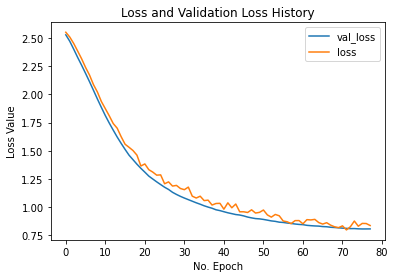

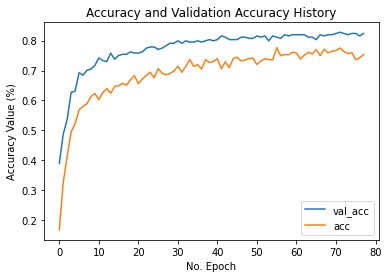

In [328]:
train_model(model_data)

# Hyperparameter Tuning
## K-Fold Cross-Validation
It seems like we're actually seeing better accuracy scores when we run k-fold CV than when we evaluate the model just once.

In [329]:
def cross_val(n_folds=4, n_layers=2, units=64, dropout_rate=0.2, batch_size=32, reg_factor=1e-5, epochs=45):
    """Uses k-fold cross-validation to evaluate a model
    
    Parameters
    ----------
    n_folds : int
        Number of folds, must be at least 2
    n_layers : int
        Number of Dense layers in model
    units : int
        Output dimension of layers
    dropout_rate : float
        Percentage of input to drop at Dropout layers
    batch_size : int
        Batch size on which to fit
    epochs : int
        Number of iterations for the model
    """
    kf = KFold(n_splits=n_folds)

    acc_per_fold = []
    loss_per_fold = []

    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((y_train, y_test), axis=0)

    fold_n = 1

    loss = 'sparse_categorical_crossentropy'
    lr = 0.001
    optimizer = tf.keras.optimizers.Adam(lr=lr)

    # Early stopping
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
    ]

    for train_index, test_index in kf.split(inputs):
        model = build_model(
            n_layers=n_layers,
            units=units,
            dropout_rate=dropout_rate,
            input_shape=X_train.shape[1:],
            reg_factor=reg_factor,
            n_classes=len(list(set(data['flair'])))
        )

        model.compile(
            loss=loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_n}...')

        history = model.fit(
            inputs[train_index],
            targets[train_index],
            epochs=epochs,
            callbacks=callbacks,
            verbose=0,
            batch_size=batch_size
        )

        # Generate generalization metrics
        scores = model.evaluate(
            inputs[test_index], targets[test_index], verbose=0)
        print(
            f'Score for fold {fold_n}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        fold_n += 1

    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

After playing around with hyperparameters, these default values for `cross_val()` seem to provide the highest accuracy.

In [330]:
cross_val()

------------------------------------------------------------------------
Training for fold 1...
Score for fold 1: loss of 1.0572391748428345; accuracy of 74.42622780799866%
------------------------------------------------------------------------
Training for fold 2...
Score for fold 2: loss of 0.8447427749633789; accuracy of 81.31147623062134%
------------------------------------------------------------------------
Training for fold 3...
Score for fold 3: loss of 0.8269950747489929; accuracy of 79.93420958518982%
------------------------------------------------------------------------
Training for fold 4...
Score for fold 4: loss of 0.855095624923706; accuracy of 81.25%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0572391748428345 - Accuracy: 74.42622780799866%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.8

# Generate DataFrame of Predictions

Validation accuracy: 0.8155737519264221, loss: 0.8188850283622742


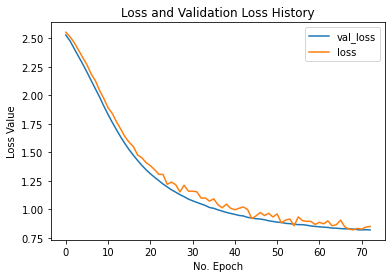

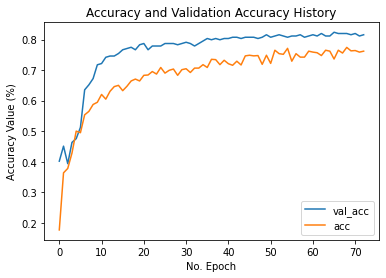

In [331]:
model = train_model(model_data, print_history=False)
prediction = model.predict(X_test)

In [332]:
encoded_predictions = [p.argmax() for p in prediction]
preds = le.inverse_transform(encoded_predictions)
ids = data.iloc[test_idxs]['id']
prediction_df = pd.DataFrame({'ids': ids, 'flair': preds}).reset_index(drop=True)
prediction_df

,ids,flair
0,fl3w6p,Politics
1,fnyudn,Scheduled
2,3wcid0,Science/Technology
3,fw0jft,Food
4,fdojuz,Politics
...,...,...
239,6flpsz,Science/Technology
240,e8be4n,Scheduled
241,fe0c0v,AskIndia
242,fkw5bq,Food
